# HMM Для прогнозирования
(Прогноз на наборе данных в конце)

In [3]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

# Модели временных рядов с переключениями

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1. Простейшая модель переключения для переменной $z_t$ состоит из двух спецификаций типа AR:

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$
 
где $|\beta|<1$ и $\epsilon_t$ независимые одинаково распределённые случайные величины с нулевым средним и дисперсией $\sigma^2_\epsilon$.

In [5]:
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
s = np.random.binomial(n=1, p=0.8, size=100)
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps

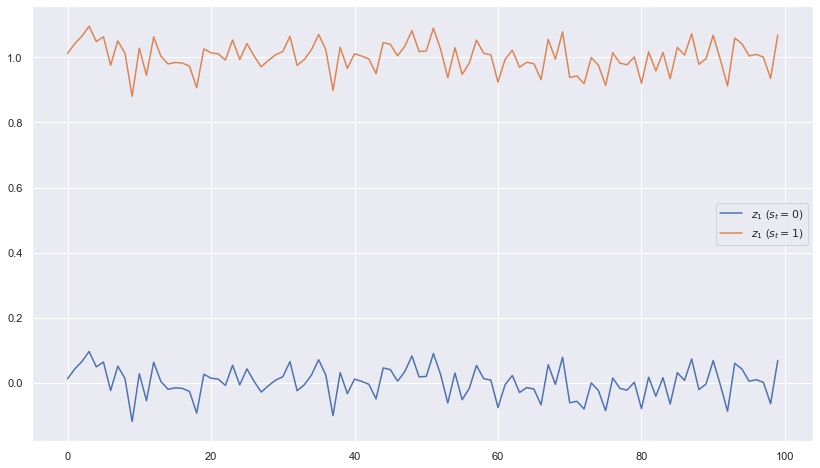

In [6]:
plt.figure(figsize=(14,8))
plt.plot(z1, label='$z_1$ ($s_t = 0$)')
plt.plot(z2, label='$z_1$ ($s_t = 1$)')
plt.legend()
plt.show()

In [7]:

z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

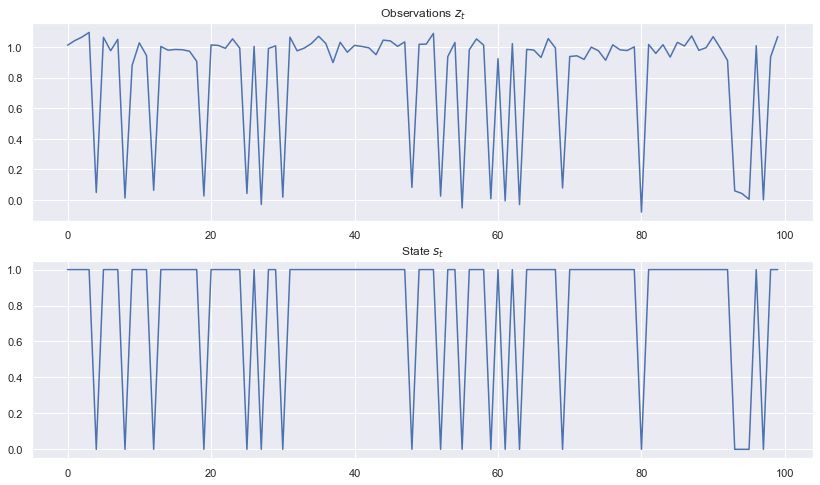

In [8]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Это стационарный AR(1) процесс со средним $\dfrac{\alpha_0}{1-\beta}$ при $s_t=0$ и переключающийся на другой стационарный AR(1) процесс со средним $\dfrac{\alpha_0+\alpha_1}{1-\beta}$, когда $s_t$ переключается с 0 на 1.

- если $a_1 \ne 0$: два динамических паттерна в зависимости от значения переменной состояния $s_t$;
- в этом случае $z_t$ управляется двумя распределениями с разным средним;
- переменная $s_t$ отвечает за переключение между этими распределениями (режимами).

Только что показанный пример: $s_t \sim Bern(p),p=0.8$.

В этой модели $s_t$ не зависит от предыдущих и будущих реализаций, поэтому $z_t$ может сильно "прыгать" (часто переключаться между разными состояниями).

# Как сгенерировать траекторию модели с марковскими переключениями?

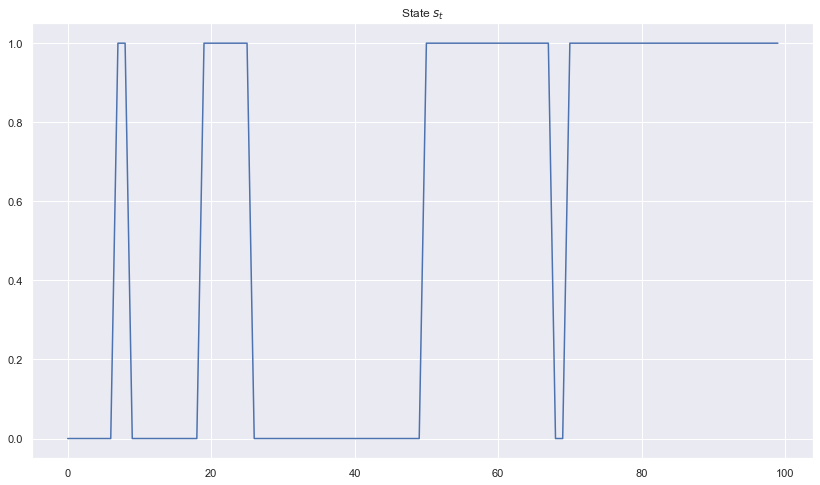

In [52]:
# 1. Генерирование марковской цепи с 2 скрытыми состояниями
P = np.array([
    [0.95, 0.05],
    [0.05, 0.95],
])
s = [0]
for t in range(99):
    distribution = P[s[-1]]
    s.append(np.random.choice([0, 1], p=distribution))

f, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.plot(s)
axs.set_title('State $s_t$')
plt.show()

In [53]:
# 2. Генерирование наблюдений из распределений, обусловленных ненаблюдаемым состоянием
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps
z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

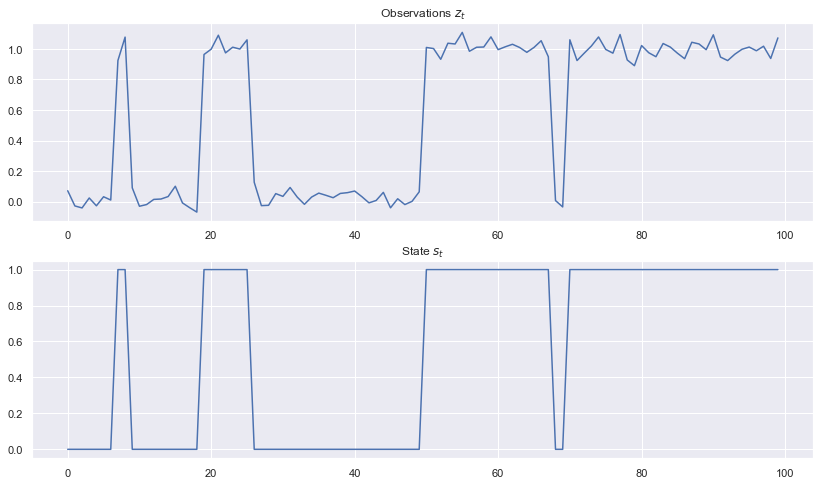

In [54]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Основные задачи теории скрытых марковских процессов:
    
- **Обучение с учителем**. Пусть есть некоторая последовательность $X$, для которой известны латентные переменные $T$. По обучающей выборке нужно оценить набор параметров $\Theta$.
- **Сегментация**. Пусть известна последовательность наблюдаемых переменных $X$ и набор параметров $\Theta$. По ним нужно построить максимально правдоподобный набор латентных переменных $T$, то есть найти $argmax_T p(T∣X,\Theta)$.
- **Обучение без учителя**. Пусть известна последовательность наблюдаемых переменных $X$ и число состояний $K$. Нужно оценить набор параметров $\Theta$. Подзадача - **нахождение маргинального распределения**: найти $p(t_n∣X,\Theta)$.
- **Прогнозирование**. Пусть известна некоторая последовательность X длины N. Нужно оценить наблюдаемый вектор в момент времени $N+1$, то есть найти $p(x_{N+1}∣X)$.

# Как сгенерировать траекторию скрытой марковской модели?

In [126]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

No handles with labels found to put in legend.


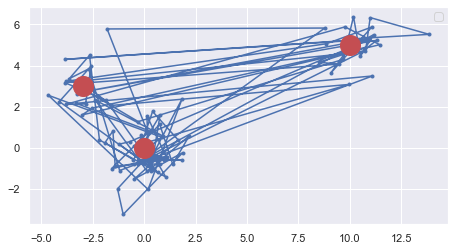

In [127]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
_ = axs.plot(X[:, 1], X[:, 0], '.-')
_ = axs.plot(model.means_[:, 1], model.means_[:, 0], 'ro', ms=20)
_ = axs.legend()
axs.set_aspect('equal')

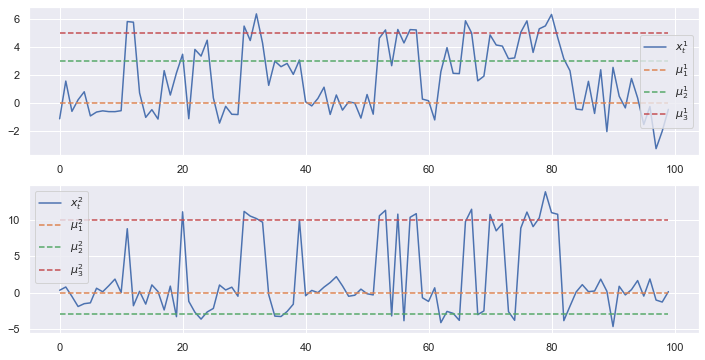

In [128]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
_ = axs[0].plot(X[:, 0], label='$x^1_t$')
for i in range(3):
    _ = axs[0].plot(range(len(X)), model.means_[i, 0] * np.ones(len(X)), '--', label='$\mu^1_{}$'.format(i+1))
_ = axs[0].legend()

_ = axs[1].plot(X[:, 1], label='$x^2_t$')
for i in range(3):
    _ = axs[1].plot(range(len(X)), model.means_[i, 1] * np.ones(len(X)), '--', label='$\mu^2_{}$'.format(i+1))
_ = axs[1].legend()

# Прогноз с использованием HMM

Загрузка скрытого гауссовского класса модели Маркова

In [17]:
from hmmlearn.hmm import GaussianHMM

In [18]:
series = pd.read_csv("нефть-brent-2010-2019.csv")["value"]

In [19]:
series

0       58.84
1       59.19
2       60.37
3       59.84
4       59.59
        ...  
2662    76.63
2663    76.62
2664    76.57
2665    76.89
2666    76.37
Name: value, Length: 2667, dtype: float64

In [20]:
values = series.values.reshape(-1,1)

In [21]:
values

array([[58.84],
       [59.19],
       [60.37],
       ...,
       [76.57],
       [76.89],
       [76.37]])

Cоздадим  и обучим гауссовский HMM. Функция этого класса требует в качестве входных данных число скрытых состояний, число итераций для запуска из алгоритма Baum-Welch

In [22]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -12508.7611438172
2 -9850.143483986707
3 -9024.521673751062
4 -8491.334882342055
5 -8054.862913006142
6 -7678.230626013771
7 -7413.939855409641
8 -7064.69239874033
9 -6680.793584395062
10 -6454.4631731327645
11 -6272.29780840694
12 -6081.05207222661
13 -5910.453650958218


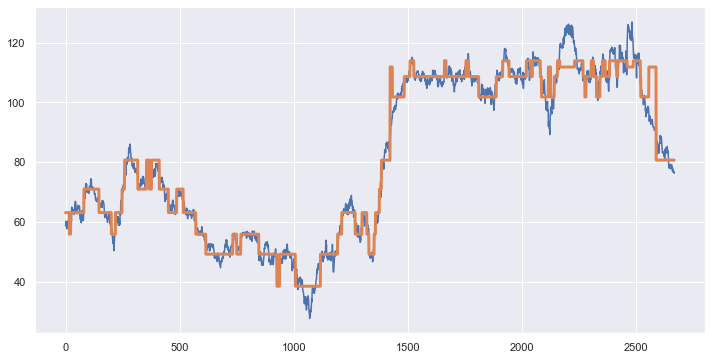

In [23]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

In [24]:
model.transmat_.shape

(10, 10)

In [25]:
print(model.transmat_)

[[9.64270517e-001 0.00000000e+000 0.00000000e+000 2.71372522e-002
  0.00000000e+000 0.00000000e+000 8.59223058e-003 0.00000000e+000
  3.30880741e-152 1.53334023e-068]
 [0.00000000e+000 9.57175622e-001 4.79718970e-259 0.00000000e+000
  2.06037333e-002 2.22206443e-002 0.00000000e+000 8.63888002e-141
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.41763572e-257 9.65184726e-001 0.00000000e+000
  0.00000000e+000 1.54210757e-002 8.82297042e-199 0.00000000e+000
  1.93941987e-002 0.00000000e+000]
 [1.25677699e-002 0.00000000e+000 0.00000000e+000 9.62041437e-001
  0.00000000e+000 0.00000000e+000 5.55340666e-019 0.00000000e+000
  0.00000000e+000 2.53907932e-002]
 [0.00000000e+000 1.25248579e-002 0.00000000e+000 0.00000000e+000
  9.81535200e-001 1.24225370e-200 0.00000000e+000 5.93994196e-003
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.47984981e-002 1.17133593e-002 0.00000000e+000
  6.69382375e-201 9.73488143e-001 0.00000000e+000 0.00000000e+000
  2.19125364e-195 0.00000000e+000